In [1]:
from google.colab import files
uploaded = files.upload()

Saving insurance.csv to insurance.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [4]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
#Prepare the data for model training. Splitting the data into features (X) and the target variable (y).
categorical_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

y = df['charges']
X = df.drop('charges', axis=1)

print("Features (X) head:")
print(X.head())
print("\nTarget (y) head:")
print(y.head())

Features (X) head:
   age     bmi  children  sex_male  smoker_yes  region_northwest  \
0   19  27.900         0     False        True             False   
1   18  33.770         1      True       False             False   
2   28  33.000         3      True       False             False   
3   33  22.705         0      True       False              True   
4   32  28.880         0      True       False              True   

   region_southeast  region_southwest  
0             False              True  
1              True             False  
2              True             False  
3             False             False  
4             False             False  

Target (y) head:
0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64


In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and train the Random Forest Regressor model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

print("Random Forest Regressor model trained successfully.")

Random Forest Regressor model trained successfully.


In [8]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

print(f"R-squared score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

R-squared score: 0.8651
Mean Absolute Error (MAE): 2550.08


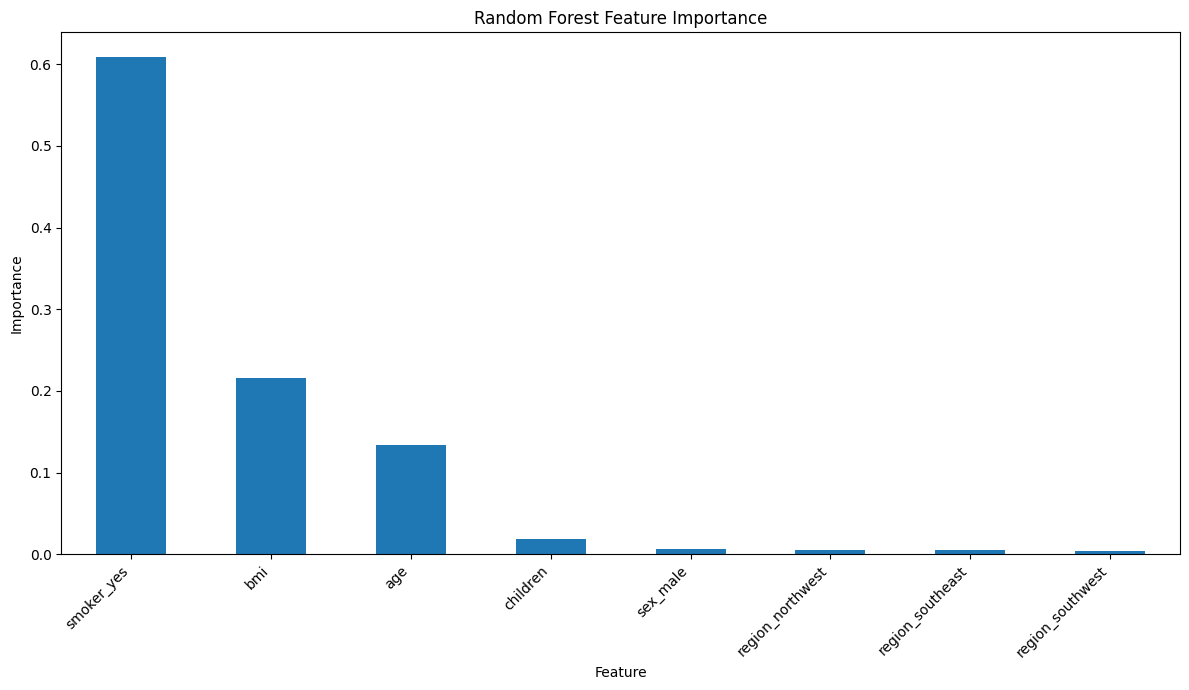

In [9]:
#plot showing most important features
# Extract feature importances
feature_importances = model.feature_importances_

# Create a Series with feature names and importances
features_df = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 7))
features_df.plot(kind='bar')
plt.title('Random Forest Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [10]:
# Perform hyperparameter tuning for the Random Forest Regressor using GridSearchCV
# 2. Define a dictionary named `param_grid` specifying the hyperparameters to tune.
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [1.0, 'sqrt'], # 'auto' is deprecated, use 1.0 instead for max_features=n_features
    'min_samples_leaf': [1, 2, 4]
}

# 3. Instantiate a `RandomForestRegressor` model with `random_state=42`.
rf_model = RandomForestRegressor(random_state=42)

# 4. Instantiate `GridSearchCV` with the `RandomForestRegressor` model, the `param_grid`, and appropriate cross-validation settings.
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# 5. Fit `grid_search` to the training data (`X_train`, `y_train`).
grid_search.fit(X_train, y_train)

# 6. Print the best parameters found by `GridSearchCV`.
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

Best parameters found by GridSearchCV:
{'max_features': 1.0, 'min_samples_leaf': 4, 'n_estimators': 200}


In [11]:
# Train a new Random Forest Regressor model using the best hyperparameters
best_params = grid_search.best_params_

# Instantiate a new RandomForestRegressor model with the best parameters
tuned_model = RandomForestRegressor(random_state=42, **best_params)

# Train this new model on the full training data
tuned_model.fit(X_train, y_train)

print("Random Forest Regressor model re-trained successfully with tuned hyperparameters.")

Random Forest Regressor model re-trained successfully with tuned hyperparameters.


In [12]:
# Make predictions on the test set using the tuned model
y_pred_tuned = tuned_model.predict(X_test)

# Calculate R-squared score for the tuned model
r2_tuned = r2_score(y_test, y_pred_tuned)

# Calculate Mean Absolute Error (MAE) for the tuned model
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

print(f"Tuned Model R-squared score: {r2_tuned:.4f}")
print(f"Tuned Model Mean Absolute Error (MAE): {mae_tuned:.2f}")
print("\n--- Comparison with untuned model ---")
print(f"Untuned Model R-squared score: {r2:.4f}")
print(f"Untuned Model Mean Absolute Error (MAE): {mae:.2f}")

Tuned Model R-squared score: 0.8775
Tuned Model Mean Absolute Error (MAE): 2468.15

--- Comparison with untuned model ---
Untuned Model R-squared score: 0.8651
Untuned Model Mean Absolute Error (MAE): 2550.08


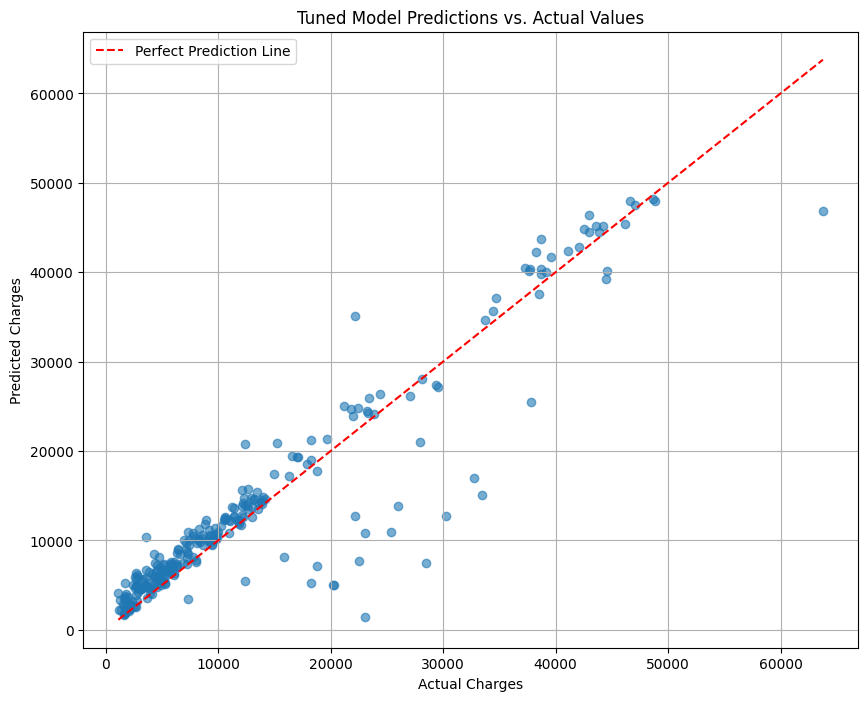

In [13]:
# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_tuned, alpha=0.6)

# Add a diagonal line for perfect predictions
min_val = min(y_test.min(), y_pred_tuned.min())
max_val = max(y_test.max(), y_pred_tuned.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction Line')

# Add title and labels
plt.title('Tuned Model Predictions vs. Actual Values')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Bootstrap confidence intervals
def calculate_metrics(y_true, y_pred):
    """Calculates R-squared and Mean Absolute Error."""
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, mae

print("Metric calculation function defined.")


Metric calculation function defined.


In [15]:
n_iterations = 2000 # Number of bootstrap samples
r2_scores_boot = []
mae_scores_boot = []

# Get indices of the test set
test_indices = np.arange(len(X_test))

for i in range(n_iterations):
    # a. Randomly sample indices with replacement from the test set's indices
    boot_indices = np.random.choice(test_indices, size=len(test_indices), replace=True)

    # b. Use these sampled indices to create bootstrap samples of X_test and y_test
    X_boot = X_test.iloc[boot_indices]
    y_boot = y_test.iloc[boot_indices]

    # c. Make predictions on X_boot using the tuned_model
    y_pred_boot = tuned_model.predict(X_boot)

    # d. Calculate the R-squared and MAE for y_boot and y_pred_boot
    r2_boot, mae_boot = calculate_metrics(y_boot, y_pred_boot)

    # e. Append these calculated R-squared and MAE values to their respective lists
    r2_scores_boot.append(r2_boot)
    mae_scores_boot.append(mae_boot)

# 5. Calculate the 2.5th and 97.5th percentiles for both bootstrapped metrics
r2_lower = np.percentile(r2_scores_boot, 2.5)
r2_upper = np.percentile(r2_scores_boot, 97.5)

mae_lower = np.percentile(mae_scores_boot, 2.5)
mae_upper = np.percentile(mae_scores_boot, 97.5)

# 6. Print the calculated 95% confidence intervals
print(f"\n95% Confidence Interval for R-squared: [{r2_lower:.4f}, {r2_upper:.4f}]")
print(f"95% Confidence Interval for MAE: [{mae_lower:.2f}, {mae_upper:.2f}]")


95% Confidence Interval for R-squared: [0.8201, 0.9217]
95% Confidence Interval for MAE: [2060.00, 2893.64]


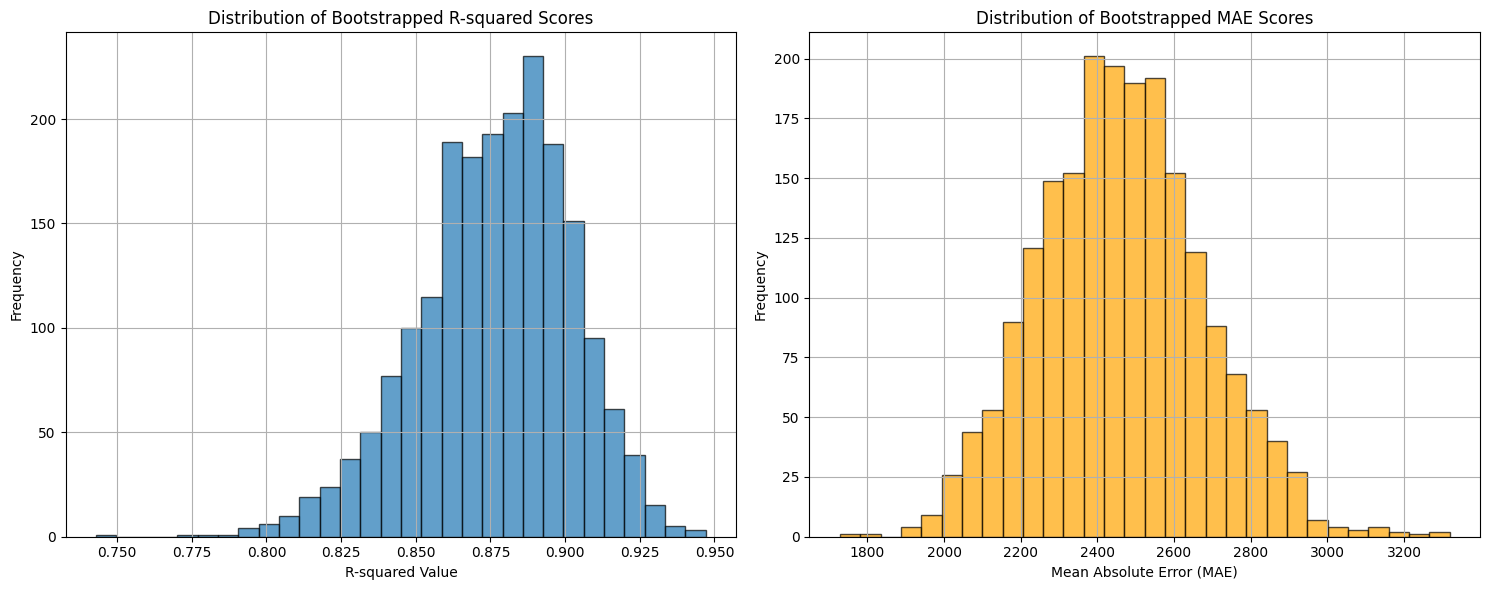

In [16]:
# Create subplots for the histograms
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram for R-squared scores
axes[0].hist(r2_scores_boot, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Bootstrapped R-squared Scores')
axes[0].set_xlabel('R-squared Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Histogram for MAE scores
axes[1].hist(mae_scores_boot, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Distribution of Bootstrapped MAE Scores')
axes[1].set_xlabel('Mean Absolute Error (MAE)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout()
plt.show()